In [ ]:
!pip install dtaidistance

     |████████████████████████████████| 1.2MB 2.6MB/s 
  ERROR: Failed building wheel for dtaidistance
  Running setup.py clean for dtaidistance
Failed to build dtaidistance
    Running setup.py install for dtaidistance ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-mhm6ax4g/dtaidistance/setup.py'"'"'; __file__='"'"'/tmp/pip-install-mhm6ax4g/dtaidistance/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-fxpykzki/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [ ]:
%cd drive/'My Drive'/PRJ-1640

/content/drive/My Drive/PRJ-1640


In [ ]:
# from dtaidistance import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import array
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import enum
import sklearn.preprocessing
import argparse
import tensorflow.compat.v1 as tf
import pickle
from sklearn.model_selection import train_test_split

In [ ]:
list_all = ['40', '81', '110-1', '180-1', '220', '250', '300', '340-1', '420-1']
list_train = ['40', '81', '180-1', '250', '300', '420-1']
list_test = ['110-1', '220', '340-1']
list_name = ['40', '81', '110', '180', '220', '250', '300', '340', '420']

In [ ]:
# list_sensor = list(range(18,1,-5))
list_sensor = []

col_mappings = {
  'outputs': ['top'],
  'inputs': ['top'],
  }

col_mappings['inputs'] += [str(i) for i in list_sensor ]
col_mappings['inputs'] += ['motion']
print(col_mappings['inputs'])

params = {}
params['total_time_steps']  = 800
params['num_encoder_steps'] = 750

['top', 'motion']


In [ ]:
def df_to_data(df, col_mappings, params):
    data_map = {}
    lags = params['total_time_steps']
    for key in col_mappings:
      cols = col_mappings[key]
      data_map[key] =  np.stack([df[cols].copy().values[i: len(df) - (lags - 1) + i, :] for i in range(lags)], axis=1)    

    data_map['outputs'] = data_map['outputs'][:, params['num_encoder_steps']:, :]
    
    return data_map

In [ ]:
# Scaler
id = list_all[-1]
df = pd.read_csv(f'CASE{id}_Acc.txt', skiprows=1, header=None, sep='\t')
df_m = pd.DataFrame()
df_m['top'] = df[1].values[7000:20000]
df_m['motion'] = df[19].values[7000:20000]
for i in list_sensor:
  df_m[f'{i}'] = df[i].values[7000:20000]

real_scalers = sklearn.preprocessing.StandardScaler().fit(df_m[col_mappings['inputs']].values)
output_scalers = sklearn.preprocessing.StandardScaler().fit(df_m[col_mappings['outputs']].values)
df_scale = df_m
df_scale[col_mappings['inputs']] = real_scalers.transform(df_m[col_mappings['inputs']].values)
data_all = df_to_data(df_scale, col_mappings, params)

In [ ]:
for i in range(len(list_train)-1):
  df = pd.read_csv(f'CASE{list_train[i]}_Acc.txt', skiprows=1, header=None, sep='\t')
  df_m = pd.DataFrame()
  df_m['top'] = df[1].values[7000:20000]
  df_m['motion'] = df[19].values[7000:20000]
  for i in list_sensor:
    df_m[f'{i}'] = df[i].values[7000:20000]

  df_scale = df_m
  df_scale[col_mappings['inputs']] = real_scalers.transform(df_m[col_mappings['inputs']].values)
  data_map = df_to_data(df_scale, col_mappings, params)
  data_all['inputs'] = np.concatenate((data_all['inputs'], data_map['inputs']), axis = 0)
  data_all['outputs'] = np.concatenate((data_all['outputs'], data_map['outputs']), axis = 0)

In [ ]:
type(data_all)
print(data_all['inputs'].shape)
print(data_all['outputs'].shape)

(73206, 800, 2)
(73206, 50, 1)


## Model

In [ ]:
N_input_size = len(col_mappings['inputs'])

params.update( {
 'dropout_rate': 0.1,
 'early_stopping_patience': 5,
 'hidden_layer_size': 160,
 'input_obs_loc': [0],
 'input_size': N_input_size,
 'known_regular_inputs': [N_input_size-1],
 'learning_rate': 0.001,
 'max_gradient_norm': 0.01,
 'minibatch_size': 256,
 'model_folder': 'saved_models/fixed',
 'multiprocessing_workers': 5,
 'num_epochs': 100,
 'num_heads': 4,
 'output_size': 1,
 'stack_size': 1,
})


In [ ]:
name, output_folder, use_tensorflow_with_gpu = 'ex2', 'ex2', 'yes'
default_keras_session = tf.keras.backend.get_session()
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
tf_config = tf.compat.v1.ConfigProto(log_device_placement=False)
tf_config.gpu_options.allow_growth = True
tf.global_variables_initializer()

num_encoder_steps = int(params['num_encoder_steps'])
output_size = int(params['output_size'])
quantiles = [0.1, 0.5, 0.9]


In [ ]:
all_inputs = tf.keras.layers.Input(shape=(params['total_time_steps'], params['input_size'],))
all_inputs

<tf.Tensor 'input_1:0' shape=(None, 800, 2) dtype=float32>

In [ ]:
def get_active_locations(x):
  """Formats sample weights for Keras training."""
  return (np.sum(x, axis=-1) > 0.0) * 1.0

def convert_real_to_embedding(x):
  return tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(params['hidden_layer_size']))(x)

def gated_residual_network(x, hidden_layer_size, output_size=None, dropout_rate=None,
                           use_time_distributed=True, additional_context=None, return_gate=False):

  # Setup skip connection
  if output_size is None:
    output_size = hidden_layer_size
    skip = x
  else:
    linear = tf.keras.layers.Dense(output_size)
    if use_time_distributed:
      linear = tf.keras.layers.TimeDistributed(linear)
    skip = linear(x)

  # Apply feedforward network
  hidden = linear_layer( hidden_layer_size, activation=None, use_time_distributed=use_time_distributed)(x) 
  hidden = tf.keras.layers.Activation('elu')(hidden)
  hidden = linear_layer(hidden_layer_size, activation=None, use_time_distributed=use_time_distributed)(hidden)
  gating_layer, gate = apply_gating_layer( hidden,output_size,dropout_rate=dropout_rate, 
                                          use_time_distributed=use_time_distributed, activation=None)

  if return_gate:
    return add_and_norm([skip, gating_layer]), gate
  else:
    return add_and_norm([skip, gating_layer])

def linear_layer(size, activation=None, use_time_distributed=False, use_bias=True):

  linear = tf.keras.layers.Dense(size, activation=activation, use_bias=use_bias)
  if use_time_distributed:
    linear = tf.keras.layers.TimeDistributed(linear)
  return linear

def apply_gating_layer(x, hidden_layer_size, dropout_rate=None, use_time_distributed=True, activation=None):

  if dropout_rate is not None:
    x = tf.keras.layers.Dropout(dropout_rate)(x)

  if use_time_distributed:
    activation_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation=activation))(x)
    
    gated_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'))(x)
  
  else:
    activation_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation=activation)(x)

    gated_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation='sigmoid')(x)

  return tf.keras.layers.Multiply()([activation_layer,gated_layer]), gated_layer

def add_and_norm(x_list):
  tmp = tf.keras.layers.Add()(x_list)
  tmp = tf.keras.layers.LayerNormalization()(tmp)
  return tmp

def get_decoder_mask(self_attn_inputs):
  len_s = tf.shape(self_attn_inputs)[1]
  bs = tf.shape(self_attn_inputs)[:1]  
  mask = tf.keras.backend.cumsum(tf.eye(len_s, batch_shape=bs), 1)
  return mask

def tensorflow_quantile_loss(y, y_pred, quantile):
  prediction_underflow = y - y_pred
  q_loss = quantile * tf.maximum(prediction_underflow, 0.) + (
      1. - quantile) * tf.maximum(-prediction_underflow, 0.)

  return tf.reduce_sum(q_loss, axis=-1)

class QuantileLossCalculator(object):
  def __init__(self, quantiles):
    self.quantiles = quantiles

  def quantile_loss(self, a, b):
    quantiles_used = set(self.quantiles)

    loss = 0.
    for i, quantile in enumerate(valid_quantiles):
      if quantile in quantiles_used:
        loss += tensorflow_quantile_loss(
            a[Ellipsis, output_size * i:output_size * (i + 1)],
            b[Ellipsis, output_size * i:output_size * (i + 1)], quantile)
    return loss  

In [ ]:
max_gradient_norm = float(params['max_gradient_norm'])
learning_rate = float(params['learning_rate'])
adam = tf.keras.optimizers.Adam(lr=learning_rate, clipnorm=max_gradient_norm)
valid_quantiles = quantiles
quantile_loss = QuantileLossCalculator(valid_quantiles).quantile_loss
minibatch_size = int(params['minibatch_size'])
n_multiprocessing_workers = int(params['multiprocessing_workers'])

In [ ]:
def temp(all_inputs, params):
  time_steps = int(params['total_time_steps'])
  combined_input_size = int(params['input_size'])
  encoder_steps = int(params['num_encoder_steps'])
  hidden_layer_size = int(params['hidden_layer_size'])
  _known_regular_input_idx = json.loads(str(params['known_regular_inputs']))
  dropout_rate = float(params['dropout_rate'])
  input_size = int(params['input_size'])
  num_regular_variables = input_size 

  regular_inputs = all_inputs[:, :, :num_regular_variables]
  # Targets
  _input_obs_loc = json.loads(str(params['input_obs_loc']))
  obs_inputs = tf.keras.backend.stack([
  convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1]) for i in _input_obs_loc], axis=-1)
  unknown_inputs = []
  for i in range(regular_inputs.shape[-1]):
    if i not in _known_regular_input_idx and i not in _input_obs_loc:
      e = convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
      unknown_inputs.append(e)

  known_regular_inputs = [
      convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
      for i in _known_regular_input_idx]

  known_combined_layer = tf.keras.backend.stack(known_regular_inputs, axis=-1)
  historical_inputs = tf.keras.backend.concatenate([known_combined_layer[:, :encoder_steps, :], obs_inputs[:, :encoder_steps, :]],axis=-1)
  future_inputs = known_combined_layer[:, encoder_steps:, :]
  _, time_steps, embedding_dim, num_inputs = historical_inputs.get_shape().as_list()
  flatten = tf.keras.backend.reshape(historical_inputs, [-1, time_steps, embedding_dim * num_inputs])
  mlp_outputs, _ = gated_residual_network( flatten, hidden_layer_size, output_size=num_inputs, dropout_rate= dropout_rate,
            use_time_distributed=True, return_gate=True)

  sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
  sparse_weights = tf.expand_dims(sparse_weights, axis=2)

  trans_emb_list = []
  for i in range(num_inputs):
    grn_output = gated_residual_network( historical_inputs[Ellipsis, i], hidden_layer_size, dropout_rate=dropout_rate,
        use_time_distributed=True)
    trans_emb_list.append(grn_output)

  transformed_embedding = tf.keras.backend.stack(trans_emb_list, axis=-1)
  combined = tf.keras.layers.Multiply()([sparse_weights, transformed_embedding])
  temporal_ctx = tf.keras.backend.sum(combined, axis=-1)
  historical_features, historical_flags = temporal_ctx, sparse_weights

  _, time_steps, embedding_dim, num_inputs = future_inputs.get_shape().as_list()
  flatten = tf.keras.backend.reshape(future_inputs, [-1, time_steps, embedding_dim * num_inputs])
  
  mlp_outputs, _ = gated_residual_network(flatten,hidden_layer_size, output_size=num_inputs,dropout_rate=dropout_rate,
            use_time_distributed=True, return_gate=True)

  sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
  sparse_weights = tf.expand_dims(sparse_weights, axis=2)

  trans_emb_list = []
  for i in range(num_inputs):
    grn_output = gated_residual_network( future_inputs[Ellipsis, i], hidden_layer_size, dropout_rate=dropout_rate,
        use_time_distributed=True)
    trans_emb_list.append(grn_output)

  transformed_embedding = tf.keras.backend.stack(trans_emb_list, axis=-1)
  combined = tf.keras.layers.Multiply()([sparse_weights, transformed_embedding])
  temporal_ctx = tf.keras.backend.sum(combined, axis=-1)
  future_features, future_flags = temporal_ctx, sparse_weights
  history_lstm, state_h, state_c = tf.compat.v1.keras.layers.CuDNNLSTM(hidden_layer_size, return_sequences=True, return_state=True, stateful=False)(historical_features)
  future_lstm = tf.compat.v1.keras.layers.CuDNNLSTM(hidden_layer_size, return_sequences=True, return_state=False, stateful=False)(future_features, initial_state=[state_h, state_c])
  lstm_layer = tf.keras.backend.concatenate([history_lstm, future_lstm], axis=1)
  lstm_layer, _ = apply_gating_layer(lstm_layer, hidden_layer_size, dropout_rate, activation=None)
  input_embeddings = tf.keras.backend.concatenate([historical_features, future_features], axis=1)
  temporal_feature_layer = add_and_norm([lstm_layer, input_embeddings])
  enriched, _ = gated_residual_network(temporal_feature_layer, hidden_layer_size, dropout_rate=dropout_rate,
          use_time_distributed=True, return_gate=True)

  # Attention
  num_heads = int(params['num_heads'])
  mask = get_decoder_mask(enriched)
  heads = []
  d_k = d_v = hidden_layer_size // num_heads

  for i in range(num_heads):
    q = tf.keras.layers.Dense(d_k, use_bias=False)(enriched)
    k = tf.keras.layers.Dense(d_k, use_bias=False)(enriched)
    v = tf.keras.layers.Dense(d_k, use_bias=False)(enriched) 
    temper = tf.sqrt(tf.cast(tf.shape(k)[-1], dtype='float32'))
    attn = tf.keras.layers.Lambda(lambda x :  tf.keras.backend.batch_dot(x[0], x[1], axes=[2, 2]) )([q, k])  
    attn = attn / temper

    if mask is not None:
      mmask = tf.keras.layers.Lambda(lambda x: (-1e+9) * (1. - tf.keras.backend.cast(x, 'float32')))(mask)  # setting to infinity
      attn = tf.keras.layers.Add()([attn, mmask])

    attn = tf.keras.layers.Activation('softmax')(attn)
    attn = tf.keras.layers.Dropout(0.0)(attn)
    head = tf.keras.layers.Lambda(lambda x: tf.keras.backend.batch_dot(x[0], x[1]))([attn, v]) 
    head_dropout = tf.keras.layers.Dropout(dropout_rate)(head)
    heads.append(head_dropout)
    
  head = tf.keras.backend.stack(heads) if num_heads > 1 else heads[0]
  x = tf.keras.backend.mean(head, axis=0) if num_heads > 1 else head
  x = tf.keras.layers.Dense(hidden_layer_size, use_bias=False)(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)  # output dropout
  x, _ = apply_gating_layer(x,hidden_layer_size,dropout_rate=dropout_rate,activation=None)
  x = add_and_norm([x, enriched])
  decoder = gated_residual_network(x, hidden_layer_size, dropout_rate=dropout_rate, use_time_distributed=True)
  decoder, _ = apply_gating_layer(decoder, hidden_layer_size, activation=None)
  transformer_layer = add_and_norm([decoder, temporal_feature_layer])
  outputs = transformer_layer[Ellipsis, num_encoder_steps:, :]
  outputs = tf.keras.layers.TimeDistributed( tf.keras.layers.Dense(output_size * len(quantiles))) (outputs)

  return outputs


In [ ]:
# Nsplit = 1000
data, val_data, labels, val_labels = train_test_split(data_all['inputs'], data_all['outputs'], test_size=0.2)
print(np.shape(data))
print(np.shape(labels))
print(np.shape(val_data))
print(np.shape(val_labels))

(58564, 800, 2)
(58564, 50, 1)
(14642, 800, 2)
(14642, 50, 1)


In [ ]:
all_callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=params['early_stopping_patience'], min_delta=1e-4),
    tf.keras.callbacks.ModelCheckpoint( filepath=os.path.join(params['model_folder'], '2aa-b.check'), monitor='val_loss',
        save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.CSVLogger('log.csv', separator=",", append=False),
    # tf.keras.callbacks.ProgbarLogger(count_mode="samples", stateful_metrics=None)  
      ]

In [ ]:
num_epochs = 10
all_inputs = tf.keras.layers.Input(shape=(params['total_time_steps'], params['input_size'],))
outputs = temp(all_inputs, params)
model = tf.keras.Model(inputs=all_inputs, outputs=outputs)
model.compile(loss=quantile_loss, optimizer=adam, sample_weight_mode='temporal')


## Train

In [ ]:
# hist= model.fit(
#         x=data,
#         y=np.concatenate([labels, labels, labels], axis=-1),
#         epochs=50,
#         batch_size=128,
#         validation_data=(val_data, np.concatenate([val_labels, val_labels, val_labels], axis=-1)),
#         callbacks=all_callbacks,
#         shuffle=True,
#         verbose = 1,
#         use_multiprocessing=True,
#         workers=n_multiprocessing_workers)

Epoch 1/50
362/458 [======================>.......] - ETA: 1:26 - loss: 0.5859

In [ ]:
# model.summary

## Test

In [ ]:
# model.load_weights(filepath=os.path.join(params['model_folder'], '2aa.check')) 
# model.load_weights(filepath=os.path.join(params['model_folder'], '2aa-100.check')) 
model.load_weights(filepath=os.path.join(params['model_folder'], '2aa-750.check')) 

In [ ]:
Nstep = params['total_time_steps'] - params['num_encoder_steps']
Linput = params['num_encoder_steps']

# Scaler
Linput = params['num_encoder_steps']
itest = 2
df = pd.read_csv(f'CASE{list_test[itest]}_Acc.txt', skiprows=1, header=None, sep='\t')
df_m = pd.DataFrame()
df_m['top'] = df[1].values[7000:20000]
df_m['motion'] = df[19].values[7000:20000]
for i in list_sensor:
  df_m[f'{i}'] = df[i].values[7000:20000]
df_scale = df_m
df_scale[col_mappings['inputs']] = real_scalers.transform(df_m[col_mappings['inputs']].values)
data_test = df_to_data(df_scale, col_mappings, params)
x_actual  =  data_test['inputs'][:-Linput:Nstep]
y_actual=  data_test['outputs'][:-Linput:Nstep]
x_actual.shape

(230, 800, 2)

In [ ]:
# motion = np.empty((12500,5))
Ltotal = len(x_actual[:,-Nstep:,1].reshape(-1,1))+Linput
motion = np.empty((Ltotal,N_input_size-1))
y_one_all = np.empty(Ltotal)
y_rep_all = np.empty(Ltotal)
y_true  = np.empty(Ltotal)

motion[0:Linput,:]  =   x_actual[0,0:Linput,1:]
motion[Linput:,:] = x_actual[:,-Nstep:,1:].reshape(-1,N_input_size-1)
# motion[Linput:,:] = x_actual[:,-Nstep:,1:].reshape(-1,1)
y_true[0:Linput] = x_actual[0,0:Linput,0]
y_true[Linput:] = x_actual[:,-Nstep:,0].reshape(-1)



In [ ]:
y_rep_all[0:Linput] = x_actual[0,0:Linput,0].copy()
y_rep_all[Linput:] = x_actual[:,-Nstep:,0].reshape(-1)
x_hybrid = x_actual[0:1,:,:].copy()

for j in range(1,200):
  istart = 1000
  idx = istart + Nstep*j
  x_hybrid[0,0:Linput,0] = y_rep_all[idx - Linput : idx]
  # x_hybrid[0,0:Linput,0] = y_true[idx - Linput : idx]
  x_hybrid[0,:,1:] = motion[idx-Linput : idx+Nstep,:]  
  y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
  y_rep_all[idx : idx+Nstep] = y_pred_rep[0,:,1]


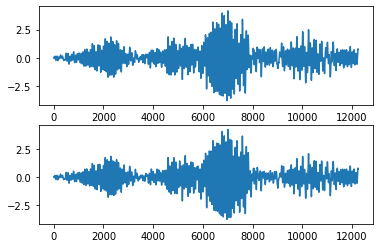

In [ ]:
plt.subplot(211)
plt.plot(y_true)
plt.subplot(212)
plt.plot(y_rep_all)

In [ ]:
y_true_sc = output_scalers.inverse_transform(y_true)
y_rep_all_sc = output_scalers.inverse_transform(y_rep_all)
distance, _ = fastdtw(y_true_sc, y_rep_all_sc, dist=euclidean) 
distance_sc = distance / math.sqrt(np.mean(y_true_sc**2))  
distance_sc / 10000 *100

5.153072304832638

32.48643171192286

## Prediction 18-single

In [ ]:

model.load_weights(filepath=os.path.join(params['model_folder'], '2aa-750.check')) 

In [ ]:
Nstep = params['total_time_steps'] - params['num_encoder_steps']
Linput = params['num_encoder_steps']

# Scaler
Linput = params['num_encoder_steps']
itest = 2
df = pd.read_csv(f'CASE{list_test[itest]}_Acc.txt', skiprows=1, header=None, sep='\t')
df_m = pd.DataFrame()
df_m['top'] = df[2].values[7000:20000]
df_m['motion'] = df[19].values[7000:20000]
for i in list_sensor:
  df_m[f'{i}'] = df[i].values[7000:20000]
df_scale = df_m
df_scale[col_mappings['inputs']] = real_scalers.transform(df_m[col_mappings['inputs']].values)
data_test = df_to_data(df_scale, col_mappings, params)
x_actual  =  data_test['inputs'][:-Linput:Nstep]
y_actual=  data_test['outputs'][:-Linput:Nstep]
x_actual.shape

In [ ]:
# motion = np.empty((12500,5))
Ltotal = len(x_actual[:,-Nstep:,1].reshape(-1,1))+Linput
motion = np.empty((Ltotal,N_input_size-1))
y_one_all = np.empty(Ltotal)
y_rep_all = np.empty(Ltotal)
y_true  = np.empty(Ltotal)

motion[0:Linput,:]  =   x_actual[0,0:Linput,1:]
motion[Linput:,:] = x_actual[:,-Nstep:,1:].reshape(-1,N_input_size-1)
# motion[Linput:,:] = x_actual[:,-Nstep:,1:].reshape(-1,1)
y_true[0:Linput] = x_actual[0,0:Linput,0]
y_true[Linput:] = x_actual[:,-Nstep:,0].reshape(-1)



In [ ]:
y_rep_all[0:Linput] = x_actual[0,0:Linput,0].copy()
y_rep_all[Linput:] = x_actual[:,-Nstep:,0].reshape(-1)
x_hybrid = x_actual[0:1,:,:].copy()

for j in range(1,200):
  istart = 1000
  idx = istart + Nstep*j
  x_hybrid[0,0:Linput,0] = y_rep_all[idx - Linput : idx]
  # x_hybrid[0,0:Linput,0] = y_true[idx - Linput : idx]
  x_hybrid[0,:,1:] = motion[idx-Linput : idx+Nstep,:]  
  y_pred_rep = model.predict(x_hybrid, workers=16, use_multiprocessing=True, batch_size=params['minibatch_size'])
  y_rep_all[idx : idx+Nstep] = y_pred_rep[0,:,1]


In [ ]:
plt.subplot(211)
plt.plot(y_true)
plt.subplot(212)
plt.plot(y_rep_all)